In [1]:
# This project focuses on brain CT image segmentation and denoising using Deep Learning.
# Al Smith and Will Newman
# c 2024

# Importing the necessary libraries:
import pydicom
from collections import defaultdict
import numpy as np
import random
import os
import gc
from glob import glob
import nibabel as nib
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from ipywidgets import widgets, interact, IntSlider
from scipy.ndimage import label
from mayavi import mlab
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom
from scipy.ndimage import gaussian_filter


## Tasks:
1) Load data from CQ500
    * Download from: http://headctstudy.qure.ai/dataset
    * Explore the DICOM Header for voxel size and imaging information (ideally the CT machine model)
    * Resolution, dose, parameters, etc.
2) Preprocess the data (noise addition, downsampling, agumentation, etc)
    * 2a) Add noise similar to low-resolution CT
    * 2b) Downsample the images to lower-resolution scale
    * 2c) Split data into train/test sets
3) Build a 3D U-Net model for segmentation
    * 3a) start with training the model on CQ500 and normal masks
    * 3b) train the model on CQ500 with noise added
    * 3c) train the model on CQ500 with images processed by denoising model
4) Denoising Model for noisy CT images
5) Train the model
6) Evaluate the model

In [2]:
# Global Variables
lb = 1040
ub = 1080

In [3]:
def save_nifti(mask, output_dir, series_uid):
    """Save the mask as a NIfTI file."""
    nifti_image = nib.Nifti1Image(mask.astype(np.int16), affine=np.eye(4))
    nib.save(nifti_image, os.path.join(output_dir, f'{series_uid}_mask.nii'))

In [4]:
# Apply window and level to a 2D numpy array of DICOM data
def apply_window_level(data, lb, ub):
    windowed_data = np.clip(data, lb, ub)
    normalized_data = (windowed_data - lb) / (ub - lb)  # Normalize between 0 and 1
    return normalized_data

# Remove unnecessary CSF spaces from the mask
def remove_mask_below_slice(volume_mask, slice_index):
    """
    Set the mask to False for all slices below the specified index.

    Parameters:
    - volume_mask: 3D numpy array (boolean) of the mask.
    - slice_index: Integer, the index below which the mask should be removed.
    """
    # Set all slices below the specified index to False
    volume_mask[:slice_index, :, :] = False
    return volume_mask


In [5]:
# Largest connected component segmentation
def create_spherical_mask(shape, center, radius):
    z, y, x = np.ogrid[:shape[0], :shape[1], :shape[2]]
    dist_from_center = (z - center[0])**2 + (y - center[1])**2 + (x - center[2])**2
    return dist_from_center <= radius**2


def largest_connected_component_3d(volume_data, lb, center, radius, threshold=0.4):
    """
    Find the largest connected component in a 3D volume that intersects with a specified spherical region.

    Parameters:
    - volume_data: 3D numpy array of DICOM data.
    - lb: Lower bound to create a binary mask for values of interest.
    - center: Tuple, the center coordinates (z, y, x) of the volume.
    - radius: Integer, the radius used to define the spherical region.

    Returns:
    - 3D mask (boolean array) of the same shape as volume_data for the largest component intersecting the sphere.
    """
    # Generate the binary mask
    slice_index = int(volume_data.shape[0] * 0.4)
    binary_mask = volume_data < lb
    binary_mask = remove_mask_below_slice(binary_mask, slice_index)

    # Label all components
    labeled_volume, num_features = label(binary_mask)
    if num_features == 0:
        return np.zeros_like(volume_data, dtype=bool)  # No components found

    # Generate the spherical mask
    spherical_mask = create_spherical_mask(volume_data.shape, center, radius)

    # Find labels intersecting the spherical mask
    intersecting_labels = np.unique(labeled_volume[spherical_mask])

    # Calculate the size of each intersecting component and select the largest
    largest_label = None
    max_size = 0
    for label_idx in intersecting_labels:
        if label_idx == 0:
            continue  # Skip background
        component_mask = labeled_volume == label_idx
        component_size = np.sum(component_mask)
        if component_size > max_size:
            max_size = component_size
            largest_label = label_idx

    return labeled_volume == largest_label if largest_label is not None else np.zeros_like(volume_data, dtype=bool)


In [7]:
def load_dicom_series_volumes(base_directory, idx):
    series_volumes = defaultdict(list)
    # Track the number of DICOM files processed
    dicom_file_count = 0
    
    # Construct the directory path
    case_dir = os.path.join(base_directory, f"CQ500CT{idx} CQ500CT{idx}", "Unknown Study")
    
    if os.path.exists(case_dir):
        # Walk through all files in the series directories within the "Unknown Study" directory
        for root, dirs, files in os.walk(case_dir):
            for dir in dirs:
                series_path = os.path.join(root, dir)
                slices = []
                # Collect all DICOM slices in the series directory
                for slice_file in os.listdir(series_path):
                    if slice_file.lower().endswith('.dcm'):
                        full_path = os.path.join(series_path, slice_file)
                        try:
                            # Read the DICOM file
                            dicom_slice = pydicom.dcmread(full_path)
                            # Append the slice and its position for later sorting
                            slices.append((dicom_slice, dicom_slice.ImagePositionPatient[2]))
                            dicom_file_count += 1
                        except Exception as e:
                            print(f"Failed to read {slice_file} as DICOM: {e}")

                # Sort slices based on the z-coordinate (ImagePositionPatient[2])
                slices.sort(key=lambda x: x[1])
                # Stack the pixel data from sorted slices to form a 3D volume
                if slices:
                    series_uid = slices[0][0].SeriesInstanceUID
                    volume = np.stack([s[0].pixel_array for s in slices])
                    series_volumes[series_uid].append(volume)

                    center = (volume.shape[0] // 2, volume.shape[1] // 2, volume.shape[2] // 2)
                    radius = int(volume.shape[0] // 6)  # Define the radius as desired

                    # Generate mask and save
                    mask = remove_mask_below_slice(largest_connected_component_3d(volume, lb, center, radius), volume.shape[0] * 2 // 5)
                    save_nifti(mask, case_dir, series_uid)
                    print("Saved mask to ", case_dir)
    else:
        print(f"Directory does not exist: {case_dir}")

    print(f"Processed {dicom_file_count} DICOM files.")
    return series_volumes

# Usage example
base_directory = '/media/hal9000/Database/CQ500_extracted'  # Adjust this path
dicom_volumes = load_dicom_series_volumes(base_directory, 0)
print(f"Number of series with loaded volumes: {len(dicom_volumes)}")

Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Saved mask to  /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Processed 987 DICOM files.
Number of series with loaded volumes: 5


# DICOM Directories that are useful
* Series Number    0, 3, 4, 5, 7, 9, 14, 15, 19, 23, 26, 28, 33, 36, 37, 39, 40, 41, 43, 45, 46, 50, 56, 58, 59, 62, 63, 64, 70, 71, 76, 78, 79, 81, 82, 83, 84, 85, 89, 91, 92, 99, 100, 101, 102, 103, 104, 105, 106, 109, 113, 116, 117
* Number of Masks: 5, 2, 1, 1, 1, 2,  2,  1,  4,  2,  3,  2,  2,  3,  2,  2,  2,  1,  1,  1,  1,  1,  2,  3,  1,  2,  2,  3,  1,  2,  2, 1,   1,   1,  1,  1,  1,  3,  3,  1,  4,  1,   2,   3,   1,   2,   1,   3,   4,   2,   2,   1,   3

# DICOM Directories with surgical pathology (less useful)
* Series Number    2, 6, 10, 11, 17, 18, 20, 22, 34, 48, 55, 57, 60, 64, 66, 68, 86, 90, 108, 111, 114,
* Number of Masks: 2, 3,  1,  2,  2,  2,  2,  2,  3,  4,  2,  2,  4,  1,  5,  1,  2,  2,   2,   2,   1,

In [8]:
# Visualize Loaded DICOM Data

# Assume dicom_volumes is already loaded
series_selection =  3
dicom =             0
series_uid = list(dicom_volumes.keys())[series_selection]
print(series_uid)
volume = dicom_volumes[series_uid][0]  # Get the first volume of the first series

center = (volume.shape[0] // 2, volume.shape[1] // 2, volume.shape[2] // 2)
radius = int(volume.shape[0] // 6)  # Define the radius as desired
#volume_mask = remove_mask_below_slice(largest_connected_component_3d(volume, lb, center, radius), volume.shape[0] * 2 // 5)
volume_mask = nib.load(f'/media/hal9000/Database/CQ500_extracted/CQ500CT{dicom} CQ500CT{dicom}/Unknown Study/{series_uid}_mask.nii').get_fdata() > 0

# Function to display a single slice
def view_slice(slice_index):
    plt.figure(figsize=(4, 4))
    processed_image = apply_window_level(volume[slice_index], lb, ub)
    
    # Overlay the 3D mask on the corresponding slice
    overlay = np.zeros(processed_image.shape + (4,))  # RGBA
    overlay[..., 0] = 1.0  # Red channel
    overlay[..., 3] = volume_mask[slice_index] * 0.5  # Semi-transparent where the mask is True

    plt.imshow(processed_image, cmap='gray')
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f'Slice {slice_index + 1}')
    plt.show()

# Slider to select the slice index
slice_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=volume.shape[0] - 1,  # max slice index
    step=1,
    description='Slice Index:',
    continuous_update=True
)

# Use ipywidgets' interactive functionality to bind the slider and the display function
widgets.interactive(view_slice, slice_index=slice_slider)

1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075


interactive(children=(IntSlider(value=0, description='Slice Index:', max=29), Output()), _dom_classes=('widget…

In [9]:
# Visualize the CSF Space Segmentation Mask in 3D dynamic viewer
def visualize_3d_mask(volume_mask):
    """Visualize a 3D mask using mayavi's volume rendering capabilities."""
    # Create a figure
    fig = mlab.figure(bgcolor=(0, 0, 0), size=(800, 800))
    
    # Visualize the volume mask: 1s are turned to True, 0s to False
    src = mlab.pipeline.scalar_field(volume_mask.astype(int))
    # Threshold to visualize only the 1s
    mlab.pipeline.iso_surface(src, contours=[volume_mask.min()+0.5, volume_mask.max()], opacity=0.4, color=(1, 0, 0))
    
    # Enhance the view
    mlab.view(azimuth=180, elevation=180, distance=400)
    mlab.roll(180)
    
    # Add axes and outline for better visual orientation
    mlab.outline(src, color=(1, 1, 1))
    mlab.axes(src, color=(1, 1, 1), xlabel='X', ylabel='Y', zlabel='Z')

    # Show the plot
    mlab.show()

# Assuming volume_mask is the mask calculated earlier
visualize_3d_mask(volume_mask)

In [10]:
# Assume dicom_volumes is already loaded
series_selection =  3
dicom =             0
series_uid = list(dicom_volumes.keys())[series_selection]
print(series_uid)
volume = dicom_volumes[series_uid][0]  # Get the first volume of the first series

# Create a directory to save the images
output_dir = './output_images'
os.makedirs(output_dir, exist_ok=True)

# Function to save a single slice as an image
def save_slice(slice_index):
    plt.figure(figsize=(4, 4))
    processed_image = apply_window_level(volume[slice_index], lb, ub)
    
    # Overlay the 3D mask on the corresponding slice
    overlay = np.zeros(processed_image.shape + (4,))  # RGBA
    overlay[..., 0] = 1.0  # Red channel
    overlay[..., 3] = volume_mask[slice_index] * 0.5  # Semi-transparent where the mask is True

    plt.imshow(processed_image, cmap='gray')
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f'Slice {slice_index + 1}')
    
    # Save the figure
    plt.savefig(os.path.join(output_dir, f'slice_{slice_index + 1}.png'))
    plt.close()

# Save all slices as images
for slice_index in range(volume.shape[0]):
    save_slice(slice_index)

1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075


In [6]:
# Task #1 Convert loaded data into torch training and validation datasets
def load_dicom_series_volumes(base_directory, indices, target_size=(32, 128, 128)):
    series_data = defaultdict(lambda: {'images': None, 'mask': None})

    for idx in indices:
        case_dir = os.path.join(base_directory, f"CQ500CT{idx} CQ500CT{idx}", "Unknown Study")
        print(f"Searching in: {case_dir}")

        if os.path.exists(case_dir):
            mask_files = {os.path.basename(f).split('_mask.nii')[0]: f for f in glob(os.path.join(case_dir, '*_mask.nii'))}

            for subdir in os.listdir(case_dir):
                subdir_path = os.path.join(case_dir, subdir)
                if not os.path.isdir(subdir_path):
                    continue

                slices = []
                series_uid = None
                for slice_file in glob(os.path.join(subdir_path, '*.dcm')):
                    try:
                        dicom_slice = pydicom.dcmread(slice_file)
                        slices.append(dicom_slice)
                        series_uid = dicom_slice.SeriesInstanceUID
                    except Exception as e:
                        print(f"Failed to read {slice_file} as DICOM: {e}")

                if slices and series_uid:
                    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
                    volume = np.stack([s.pixel_array for s in slices])

                    # Resize the volume
                    resize_factor = np.array(target_size) / np.array(volume.shape)
                    resized_volume = zoom(volume, resize_factor)
                    series_data[series_uid]['images'] = resized_volume

                    if series_uid in mask_files:
                        mask_file = mask_files[series_uid]
                        mask = nib.load(mask_file).get_fdata()

                        # Resize the mask
                        resized_mask = zoom(mask, resize_factor)
                        resized_mask = (resized_mask > 0.5).astype(np.float32)
                        series_data[series_uid]['mask'] = resized_mask
                        print(f"Mask found and loaded for series UID {series_uid}")
        else:
            print(f"No directory found for index {idx}")

    filtered_data = {uid: data for uid, data in series_data.items() if data['images'] is not None and data['mask'] is not None}
    return filtered_data

# Usage example
base_directory = '/media/hal9000/Database/CQ500_extracted/'
# all indices from "good scans", where first comment is 10 scans, second is 64, and third is 100, spaces indicate where to comment out
indices = [0, 3, 4, 5, 7]#, \
          #  9, 14, 15, 19, 23, 26, 28, 33, 36, 37, 39, 40, 41, 43, 45, 46, 50, 56, 58, 59, 62, 63, \
          #  64, 70, 71, 76, 78, 79, 81, 82, 83, 84, \
          #  85, 89, 91, 92, 99, 100, 101, 102, 103, 104, 105, 55, 109, 113, 116, 117]
loaded_data = load_dicom_series_volumes(base_directory, indices)
print(f"Loaded {len(loaded_data)} series with both images and masks.")

Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521714313.2033589
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT3 CQ500CT3/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713849.1919689
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713848.1919208
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT4 CQ500CT4/Unknown Study


/home/hal9000/.local/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (16-bit) doesn't match the JPEG 2000 data (14-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/home/hal9000/.local/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (16-bit) doesn't match the JPEG 2000 data (13-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713544.1838788
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT5 CQ500CT5/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713672.1872547
Searching in: /media/hal9000/Database/CQ500_extracted/CQ500CT7 CQ500CT7/Unknown Study
Mask found and loaded for series UID 1.2.276.0.7230010.3.1.3.296485376.1.1521713385.1794631
Loaded 10 series with both images and masks.


In [7]:
# Make sure images are loaded correctly

def visualize_images_and_masks(image_volume, mask_volume):
    """
    Visualize DICOM images with their corresponding masks using matplotlib and ipywidgets.

    Parameters:
    - image_volume: 3D numpy array of the DICOM images.
    - mask_volume: 3D numpy array of the mask data.
    """

    image_volume = np.clip(image_volume, lb, ub)  # Apply window and level

    # Create a colormap that includes transparency
    colors = [(0,0,0,0)] + [(plt.cm.Reds(i)) for i in range(1,256)]
    RedAlpha = mcolors.LinearSegmentedColormap.from_list('RedAlpha', colors, N=256)

    # Function to update the plot for each slice
    def plot_slice(slice_index):
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
        # Show the mask slice
        ax.imshow(image_volume[slice_index], cmap='gray')
        ax.imshow(mask_volume[slice_index], alpha=0.75, cmap=RedAlpha)  # Overlay mask
        ax.set_title('Image with Mask')
        ax.axis('off')

        plt.show()

    # Create a slider to scroll through slices
    interact(plot_slice, slice_index=IntSlider(min=0, max=image_volume.shape[0] - 1, step=1, value=image_volume.shape[0] // 2))

# Example usage with the first loaded series (assuming loaded_data is available)
series_uid = random.choice(list(loaded_data.keys()))    # Randomly select a series
print(series_uid)
visualize_images_and_masks(loaded_data[series_uid]['images'], loaded_data[series_uid]['mask'])

1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631


interactive(children=(IntSlider(value=16, description='slice_index', max=31), Output()), _dom_classes=('widget…

In [8]:
class CTScanDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        uid, data = list(self.data.items())[idx]
        image = np.array(data['images'])  # Convert memmap to regular numpy array
        mask = np.array(data['mask'])  # Convert memmap to regular numpy array
        return image, mask

In [9]:
# Define a custom collate function

batch_size = 6

def collate_fn(batch):
    images, masks = zip(*batch)
    
    # Convert the numpy arrays to PyTorch tensors
    images = [torch.from_numpy(image.astype(np.float32)) for image in images]
    masks = [torch.from_numpy(mask.astype(np.uint8)) for mask in masks]
    
    # Determine the maximum size along the 0 axis
    max_size = max(image.shape[0] for image in images)
    
    # Pad the images and masks to the maximum size
    images = [F.pad(image.float(), (0, 0, 0, 0, 0, max_size - image.shape[0])) for image in images]
    masks = [F.pad(mask.float(), (0, 0, 0, 0, 0, max_size - mask.shape[0])) for mask in masks]
    
    return torch.stack(images), torch.stack(masks)

# Data Split
def create_train_test_split(data_dict, test_size=0.25, random_state=42):
    # Create a list of keys, which are the series UIDs
    series_uids = list(data_dict.keys())
    
    # Split the series UIDs into train and test sets
    train_uids, test_uids = train_test_split(series_uids, test_size=test_size, random_state=random_state)
    
    # Create subsets for train and test from the main dataset
    train_dataset = {uid: data_dict[uid] for uid in train_uids}
    test_dataset = {uid: data_dict[uid] for uid in test_uids}
    
    return train_dataset, test_dataset

# Assume 'loaded_data' is your fully loaded dataset dictionary
train_data, test_data = create_train_test_split(loaded_data, test_size=0.4)

# Assuming a transform defined earlier
train_dataset = CTScanDataset(train_data)
test_dataset = CTScanDataset(test_data)

# Create DataLoaders for both train and test datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Task #2 Preprocess the data
# Task #2b Add noise similar to low-resolution CT

# Task #2c Downsample the images to lower-resolution scale

# Task #2d Split the data into training and testing sets

In [ ]:
# Task #3 Build a 3D U-Net model for segmentation
# Task #3a Start with training the model on CQ500 and normal masks

# Task #3b Train the model on CQ500 with noise added

# Task #3c Train the model on CQ500 with images processed by denoising model

In [10]:
# Task 3 Using nnU-Net architecture as described in the paper: https://arxiv.org/abs/2404.09556

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffZ = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffY = torch.tensor([x2.size()[3] - x1.size()[3]])
        diffX = torch.tensor([x2.size()[4] - x1.size()[4]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2,
                        diffZ // 2, diffZ - diffZ // 2])
        # if you have padding issues, see below
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.up1 = Up(768, 256, bilinear)
        self.up2 = Up(384, 128, bilinear)
        self.up3 = Up(192, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
# Use Sørensen-Dice coefficient as the loss function
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Convert probabilities to binary predictions
        # For a multi-class problem, consider each class channel as a binary problem
        inputs = torch.sigmoid(inputs)  # Apply sigmoid to squash outputs to [0,1]
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model = UNet3D(n_channels=1, n_classes=1).to(device)
#criterion = DiceLoss()
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 200
loss = 0.0
loss_history = []
val_loss_history = []
def to_grayscale(images):
    return images.mean(dim=1, keepdim=True).squeeze(1)

Device:  cuda


In [21]:
# garbace collection to prevent gpu memory overflow
gc.collect()
model = None
torch.cuda.empty_cache()

In [30]:
# Training Loop
squeeze_factor = 1

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_val_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (images, masks) in progress_bar:
        images = images.float().to(device)
        masks = masks.float().to(device)

        images = images.unsqueeze(squeeze_factor)
        masks = masks.unsqueeze(squeeze_factor)

        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=images.size()[2:])
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        del images, masks, outputs
        torch.cuda.empty_cache()

        # Update the progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_history.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        running_val_loss = 0.0
        for i, (images, masks) in enumerate(test_loader):
            images = images.float().to(device)
            masks = masks.float().to(device)
            
            images = images.unsqueeze(squeeze_factor)
            masks = masks.unsqueeze(squeeze_factor)

            # Forward pass
            outputs = model(images)
            val_loss = criterion(outputs, masks)

            running_val_loss += val_loss.item()

        # Calculate the average validation loss for the epoch
        average_val_loss = running_val_loss / len(test_loader)
        val_loss_history.append(average_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {average_val_loss:.4f}")

Epoch 1/100:   0%|          | 0/8 [00:00<?, ?it/s]/home/hal9000/.local/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 1/100: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.978]


Epoch [1/100], Average Loss: 0.9873
Epoch [1/100], Average Validation Loss: 0.9902


Epoch 2/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.977]


Epoch [2/100], Average Loss: 0.9828
Epoch [2/100], Average Validation Loss: 0.9826


Epoch 3/100: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.981]


Epoch [3/100], Average Loss: 0.9818
Epoch [3/100], Average Validation Loss: 0.9807


Epoch 4/100: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.984]


Epoch [4/100], Average Loss: 0.9815
Epoch [4/100], Average Validation Loss: 0.9782


Epoch 5/100: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.976]


Epoch [5/100], Average Loss: 0.9807
Epoch [5/100], Average Validation Loss: 0.9753


Epoch 6/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.974]


Epoch [6/100], Average Loss: 0.9802
Epoch [6/100], Average Validation Loss: 0.9751


Epoch 7/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.982]


Epoch [7/100], Average Loss: 0.9801
Epoch [7/100], Average Validation Loss: 0.9741


Epoch 8/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.972]


Epoch [8/100], Average Loss: 0.9795
Epoch [8/100], Average Validation Loss: 0.9736


Epoch 9/100: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.981]


Epoch [9/100], Average Loss: 0.9795
Epoch [9/100], Average Validation Loss: 0.9742


Epoch 10/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.968]


Epoch [10/100], Average Loss: 0.9793
Epoch [10/100], Average Validation Loss: 0.9731


Epoch 11/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.966]


Epoch [11/100], Average Loss: 0.9787
Epoch [11/100], Average Validation Loss: 0.9723


Epoch 12/100: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=0.983]


Epoch [12/100], Average Loss: 0.9790
Epoch [12/100], Average Validation Loss: 0.9721


Epoch 13/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.983]


Epoch [13/100], Average Loss: 0.9785
Epoch [13/100], Average Validation Loss: 0.9712


Epoch 14/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.971]


Epoch [14/100], Average Loss: 0.9778
Epoch [14/100], Average Validation Loss: 0.9705


Epoch 15/100: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it, loss=0.985]


Epoch [15/100], Average Loss: 0.9779
Epoch [15/100], Average Validation Loss: 0.9702


Epoch 16/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.986]


Epoch [16/100], Average Loss: 0.9774
Epoch [16/100], Average Validation Loss: 0.9700


Epoch 17/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.987]


Epoch [17/100], Average Loss: 0.9772
Epoch [17/100], Average Validation Loss: 0.9691


Epoch 18/100: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it, loss=0.989]


Epoch [18/100], Average Loss: 0.9770
Epoch [18/100], Average Validation Loss: 0.9699


Epoch 19/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.975]


Epoch [19/100], Average Loss: 0.9761
Epoch [19/100], Average Validation Loss: 0.9690


Epoch 20/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.983]


Epoch [20/100], Average Loss: 0.9759
Epoch [20/100], Average Validation Loss: 0.9692


Epoch 21/100: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it, loss=0.976]


Epoch [21/100], Average Loss: 0.9755
Epoch [21/100], Average Validation Loss: 0.9674


Epoch 22/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.978]


Epoch [22/100], Average Loss: 0.9752
Epoch [22/100], Average Validation Loss: 0.9687


Epoch 23/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.973]


Epoch [23/100], Average Loss: 0.9746
Epoch [23/100], Average Validation Loss: 0.9673


Epoch 24/100: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it, loss=0.984]


Epoch [24/100], Average Loss: 0.9748
Epoch [24/100], Average Validation Loss: 0.9669


Epoch 25/100: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it, loss=0.978]


Epoch [25/100], Average Loss: 0.9745
Epoch [25/100], Average Validation Loss: 0.9674


Epoch 26/100: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.983]


Epoch [26/100], Average Loss: 0.9741
Epoch [26/100], Average Validation Loss: 0.9649


Epoch 27/100: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it, loss=0.969]


Epoch [27/100], Average Loss: 0.9730
Epoch [27/100], Average Validation Loss: 0.9645


Epoch 28/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.982]


Epoch [28/100], Average Loss: 0.9730
Epoch [28/100], Average Validation Loss: 0.9678


Epoch 29/100: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.981]


Epoch [29/100], Average Loss: 0.9726
Epoch [29/100], Average Validation Loss: 0.9640


Epoch 30/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.981]


Epoch [30/100], Average Loss: 0.9723
Epoch [30/100], Average Validation Loss: 0.9623


Epoch 31/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.976]


Epoch [31/100], Average Loss: 0.9716
Epoch [31/100], Average Validation Loss: 0.9630


Epoch 32/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.957]


Epoch [32/100], Average Loss: 0.9705
Epoch [32/100], Average Validation Loss: 0.9627


Epoch 33/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.976]


Epoch [33/100], Average Loss: 0.9703
Epoch [33/100], Average Validation Loss: 0.9608


Epoch 34/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.955]


Epoch [34/100], Average Loss: 0.9695
Epoch [34/100], Average Validation Loss: 0.9625


Epoch 35/100: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, loss=0.964]


Epoch [35/100], Average Loss: 0.9693
Epoch [35/100], Average Validation Loss: 0.9593


Epoch 36/100: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.959]


Epoch [36/100], Average Loss: 0.9687
Epoch [36/100], Average Validation Loss: 0.9593


Epoch 37/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.975]


Epoch [37/100], Average Loss: 0.9684
Epoch [37/100], Average Validation Loss: 0.9584


Epoch 38/100: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=0.957]


Epoch [38/100], Average Loss: 0.9672
Epoch [38/100], Average Validation Loss: 0.9572


Epoch 39/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.951]


Epoch [39/100], Average Loss: 0.9662
Epoch [39/100], Average Validation Loss: 0.9589


Epoch 40/100: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=0.96] 


Epoch [40/100], Average Loss: 0.9660
Epoch [40/100], Average Validation Loss: 0.9605


Epoch 41/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.965]


Epoch [41/100], Average Loss: 0.9653
Epoch [41/100], Average Validation Loss: 0.9565


Epoch 42/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.949]


Epoch [42/100], Average Loss: 0.9644
Epoch [42/100], Average Validation Loss: 0.9562


Epoch 43/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.958]


Epoch [43/100], Average Loss: 0.9637
Epoch [43/100], Average Validation Loss: 0.9538


Epoch 44/100: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=0.981]


Epoch [44/100], Average Loss: 0.9638
Epoch [44/100], Average Validation Loss: 0.9539


Epoch 45/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.942]


Epoch [45/100], Average Loss: 0.9618
Epoch [45/100], Average Validation Loss: 0.9529


Epoch 46/100: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=0.958]


Epoch [46/100], Average Loss: 0.9615
Epoch [46/100], Average Validation Loss: 0.9548


Epoch 47/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.974]


Epoch [47/100], Average Loss: 0.9617
Epoch [47/100], Average Validation Loss: 0.9520


Epoch 48/100: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s, loss=0.964]


Epoch [48/100], Average Loss: 0.9604
Epoch [48/100], Average Validation Loss: 0.9496


Epoch 49/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.979]


Epoch [49/100], Average Loss: 0.9603
Epoch [49/100], Average Validation Loss: 0.9480


Epoch 50/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.962]


Epoch [50/100], Average Loss: 0.9583
Epoch [50/100], Average Validation Loss: 0.9466


Epoch 51/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.929]


Epoch [51/100], Average Loss: 0.9566
Epoch [51/100], Average Validation Loss: 0.9462


Epoch 52/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.952]


Epoch [52/100], Average Loss: 0.9564
Epoch [52/100], Average Validation Loss: 0.9447


Epoch 53/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.978]


Epoch [53/100], Average Loss: 0.9565
Epoch [53/100], Average Validation Loss: 0.9415


Epoch 54/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.961]


Epoch [54/100], Average Loss: 0.9546
Epoch [54/100], Average Validation Loss: 0.9430


Epoch 55/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.946]


Epoch [55/100], Average Loss: 0.9528
Epoch [55/100], Average Validation Loss: 0.9438


Epoch 56/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.94] 


Epoch [56/100], Average Loss: 0.9518
Epoch [56/100], Average Validation Loss: 0.9440


Epoch 57/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.968]


Epoch [57/100], Average Loss: 0.9522
Epoch [57/100], Average Validation Loss: 0.9403


Epoch 58/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.938]


Epoch [58/100], Average Loss: 0.9504
Epoch [58/100], Average Validation Loss: 0.9422


Epoch 59/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.912]


Epoch [59/100], Average Loss: 0.9481
Epoch [59/100], Average Validation Loss: 0.9349


Epoch 60/100: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=0.955]


Epoch [60/100], Average Loss: 0.9477
Epoch [60/100], Average Validation Loss: 0.9351


Epoch 61/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.952]


Epoch [61/100], Average Loss: 0.9471
Epoch [61/100], Average Validation Loss: 0.9329


Epoch 62/100: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s, loss=0.915]


Epoch [62/100], Average Loss: 0.9440
Epoch [62/100], Average Validation Loss: 0.9306


Epoch 63/100: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.956]


Epoch [63/100], Average Loss: 0.9440
Epoch [63/100], Average Validation Loss: 0.9389


Epoch 64/100: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s, loss=0.921]


Epoch [64/100], Average Loss: 0.9430
Epoch [64/100], Average Validation Loss: 0.9330


Epoch 65/100: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s, loss=0.945]


Epoch [65/100], Average Loss: 0.9423
Epoch [65/100], Average Validation Loss: 0.9324


Epoch 66/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.948]


Epoch [66/100], Average Loss: 0.9415
Epoch [66/100], Average Validation Loss: 0.9263


Epoch 67/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.928]


Epoch [67/100], Average Loss: 0.9391
Epoch [67/100], Average Validation Loss: 0.9294


Epoch 68/100: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s, loss=0.908]


Epoch [68/100], Average Loss: 0.9374
Epoch [68/100], Average Validation Loss: 0.9248


Epoch 69/100: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s, loss=0.921]


Epoch [69/100], Average Loss: 0.9348
Epoch [69/100], Average Validation Loss: 0.9250


Epoch 70/100: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, loss=0.959]


Epoch [70/100], Average Loss: 0.9340
Epoch [70/100], Average Validation Loss: 0.9206


Epoch 71/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.941]


Epoch [71/100], Average Loss: 0.9305
Epoch [71/100], Average Validation Loss: 0.9171


Epoch 72/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.91] 


Epoch [72/100], Average Loss: 0.9267
Epoch [72/100], Average Validation Loss: 0.9152


Epoch 73/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.912]


Epoch [73/100], Average Loss: 0.9274
Epoch [73/100], Average Validation Loss: 0.9213


Epoch 74/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.952]


Epoch [74/100], Average Loss: 0.9267
Epoch [74/100], Average Validation Loss: 0.9199


Epoch 75/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.965]


Epoch [75/100], Average Loss: 0.9241
Epoch [75/100], Average Validation Loss: 0.9111


Epoch 76/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.951]


Epoch [76/100], Average Loss: 0.9214
Epoch [76/100], Average Validation Loss: 0.9097


Epoch 77/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.933]


Epoch [77/100], Average Loss: 0.9180
Epoch [77/100], Average Validation Loss: 0.9023


Epoch 78/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.896]


Epoch [78/100], Average Loss: 0.9147
Epoch [78/100], Average Validation Loss: 0.9065


Epoch 79/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.897]


Epoch [79/100], Average Loss: 0.9145
Epoch [79/100], Average Validation Loss: 0.8952


Epoch 80/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.917]


Epoch [80/100], Average Loss: 0.9111
Epoch [80/100], Average Validation Loss: 0.8944


Epoch 81/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.937]


Epoch [81/100], Average Loss: 0.9102
Epoch [81/100], Average Validation Loss: 0.8993


Epoch 82/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.95] 


Epoch [82/100], Average Loss: 0.9083
Epoch [82/100], Average Validation Loss: 0.8890


Epoch 83/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.926]


Epoch [83/100], Average Loss: 0.9032
Epoch [83/100], Average Validation Loss: 0.8931


Epoch 84/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.876]


Epoch [84/100], Average Loss: 0.9013
Epoch [84/100], Average Validation Loss: 0.8862


Epoch 85/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.938]


Epoch [85/100], Average Loss: 0.8981
Epoch [85/100], Average Validation Loss: 0.8790


Epoch 86/100: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s, loss=0.865]


Epoch [86/100], Average Loss: 0.8908
Epoch [86/100], Average Validation Loss: 0.8871


Epoch 87/100: 100%|██████████| 8/8 [00:07<00:00,  1.00it/s, loss=0.84] 


Epoch [87/100], Average Loss: 0.8871
Epoch [87/100], Average Validation Loss: 0.8826


Epoch 88/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.901]


Epoch [88/100], Average Loss: 0.8875
Epoch [88/100], Average Validation Loss: 0.8677


Epoch 89/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.794]


Epoch [89/100], Average Loss: 0.8817
Epoch [89/100], Average Validation Loss: 0.8767


Epoch 90/100: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it, loss=0.885]


Epoch [90/100], Average Loss: 0.8807
Epoch [90/100], Average Validation Loss: 0.8702


Epoch 91/100: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it, loss=0.932]


Epoch [91/100], Average Loss: 0.8812
Epoch [91/100], Average Validation Loss: 0.8773


Epoch 92/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.783]


Epoch [92/100], Average Loss: 0.8719
Epoch [92/100], Average Validation Loss: 0.8668


Epoch 93/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.917]


Epoch [93/100], Average Loss: 0.8710
Epoch [93/100], Average Validation Loss: 0.8597


Epoch 94/100: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it, loss=0.803]


Epoch [94/100], Average Loss: 0.8639
Epoch [94/100], Average Validation Loss: 0.8475


Epoch 95/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.898]


Epoch [95/100], Average Loss: 0.8637
Epoch [95/100], Average Validation Loss: 0.8461


Epoch 96/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.895]


Epoch [96/100], Average Loss: 0.8611
Epoch [96/100], Average Validation Loss: 0.8391


Epoch 97/100: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it, loss=0.885]


Epoch [97/100], Average Loss: 0.8516
Epoch [97/100], Average Validation Loss: 0.8506


Epoch 98/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.867]


Epoch [98/100], Average Loss: 0.8459
Epoch [98/100], Average Validation Loss: 0.8300


Epoch 99/100: 100%|██████████| 8/8 [00:08<00:00,  1.00s/it, loss=0.844]


Epoch [99/100], Average Loss: 0.8384
Epoch [99/100], Average Validation Loss: 0.8321


Epoch 100/100: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it, loss=0.774]


Epoch [100/100], Average Loss: 0.8323
Epoch [100/100], Average Validation Loss: 0.8427


In [34]:
# Training Loop
squeeze_factor = 1
num_epochs = 1000  # Set this to your desired number of epochs

progress_bar_epochs = tqdm(range(num_epochs), total=num_epochs, desc="Training Progress")

for epoch in progress_bar_epochs:
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_val_loss = 0.0

    for i, (images, masks) in enumerate(train_loader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        images = images.unsqueeze(squeeze_factor)
        masks = masks.unsqueeze(squeeze_factor)

        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.interpolate(outputs, size=images.size()[2:])
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        del images, masks, outputs
        torch.cuda.empty_cache()

    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_history.append(average_loss)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        running_val_loss = 0.0
        for i, (images, masks) in enumerate(test_loader):
            images = images.float().to(device)
            masks = masks.float().to(device)
            
            images = images.unsqueeze(squeeze_factor)
            masks = masks.unsqueeze(squeeze_factor)

            # Forward pass
            outputs = model(images)
            val_loss = criterion(outputs, masks)

            running_val_loss += val_loss.item()

        # Calculate the average validation loss for the epoch
        average_val_loss = running_val_loss / len(test_loader)
        val_loss_history.append(average_val_loss)

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        progress_bar_epochs.set_postfix({'Epoch': epoch+1, 'Avg Loss': average_loss, 'Avg Val Loss': average_val_loss})

Training Progress:  30%|███       | 300/1000 [1:35:41<3:43:15, 19.14s/it, Epoch=300, Avg Loss=0.05, Avg Val Loss=0.262]  


KeyboardInterrupt: 

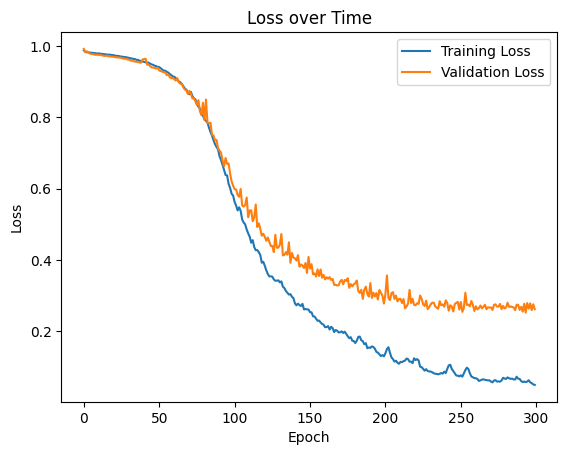

In [35]:
# Plotting the loss history and validation loss history
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.legend()
plt.show()


In [10]:
# Make sure images are loaded correctly

def visualize_images_and_masks(image_volume, mask_volume, pred_mask_volume):
    """
    Visualize DICOM images with their corresponding masks using matplotlib and ipywidgets.

    Parameters:
    - image_volume: 3D numpy array of the DICOM images.
    - mask_volume: 3D numpy array of the mask data.
    """
    image_volume = np.clip(image_volume, lb, ub)

    # Create a colormap that includes transparency
    colors = [(0,0,0,0)] + [(plt.cm.Reds(i)) for i in range(1,256)]
    RedAlpha = mcolors.LinearSegmentedColormap.from_list('RedAlpha', colors, N=256)

    colors = [(0,0,0,0)] + [(plt.cm.Blues(i)) for i in range(1,256)]
    BlueAlpha = mcolors.LinearSegmentedColormap.from_list('BlueAlpha', colors, N=256)

    # Function to update the plot for each slice
    def plot_slice(slice_index):
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        
        # Show the ground truth mask slice
        axs[0].imshow(image_volume[slice_index], cmap='gray')
        axs[0].imshow(mask_volume[slice_index], alpha=0.75, cmap=RedAlpha)  # Overlay mask
        axs[0].set_title('Image with Ground Truth Mask')
        axs[0].axis('off')

        # Show the predicted mask slice
        axs[1].imshow(image_volume[slice_index], cmap='gray')
        axs[1].imshow(pred_mask_volume[slice_index], alpha=0.75, cmap=BlueAlpha)  # Overlay mask
        axs[1].set_title('Image with Predicted Mask')
        axs[1].axis('off')

        plt.show()

    # Create a slider to scroll through slices
    interact(plot_slice, slice_index=IntSlider(min=0, max=image_volume.shape[0] - 1, step=1, value=image_volume.shape[0] // 2))

series_uid = random.choice(list(loaded_data.keys()))    # Randomly select a series

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    images = torch.from_numpy(loaded_data[series_uid]['images'].astype(np.float32))
    # Add a channel dimension (assuming grayscale images)
    images = images.unsqueeze(0)
    # Add a batch dimension
    images = images.unsqueeze(0)
    # Ensure the tensor is on the correct device
    images = images.to(device)
    outputs = model(images)  # Get the model's predictions

# The outputs are likely in the form of logits or probabilities. 
# You might need to apply a threshold or take the argmax to get the final predicted mask.
# This depends on how your model was trained.


pred_mask_volume = (outputs > 0).float().squeeze(0)[0].cpu().numpy()  # Example for a multi-class segmentation model

visualize_images_and_masks(loaded_data[series_uid]['images'], loaded_data[series_uid]['mask'], pred_mask_volume)

NameError: name 'loaded_data' is not defined

In [14]:
def load_dicom_series_volumes(base_directory, idx, target_size=(32, 128, 128)):
    series_volumes = defaultdict(list)
    # Track the number of DICOM files processed
    dicom_file_count = 0
    
    # Construct the directory path
    case_dir = os.path.join(base_directory, f"CQ500CT{idx} CQ500CT{idx}", "Unknown Study")
    
    if os.path.exists(case_dir):
        # Walk through all files in the series directories within the "Unknown Study" directory
        for root, dirs, files in os.walk(case_dir):
            for dir in dirs:
                series_path = os.path.join(root, dir)
                slices = []
                # Collect all DICOM slices in the series directory
                for slice_file in os.listdir(series_path):
                    if slice_file.lower().endswith('.dcm'):
                        full_path = os.path.join(series_path, slice_file)
                        try:
                            # Read the DICOM file
                            dicom_slice = pydicom.dcmread(full_path)
                            # Append the slice and its position for later sorting
                            slices.append((dicom_slice, dicom_slice.ImagePositionPatient[2]))
                            dicom_file_count += 1
                        except Exception as e:
                            print(f"Failed to read {slice_file} as DICOM: {e}")

                # Sort slices based on the z-coordinate (ImagePositionPatient[2])
                slices.sort(key=lambda x: x[1])
                # Stack the pixel data from sorted slices to form a 3D volume
                if slices:
                    series_uid = slices[0][0].SeriesInstanceUID
                    volume = np.stack([s[0].pixel_array for s in slices])

                    # Resize the volume
                    resize_factor = np.array(target_size) / np.array(volume.shape)
                    resized_volume = zoom(volume, resize_factor)
                    series_volumes[series_uid].append(resized_volume)

    else:
        print(f"Directory does not exist: {case_dir}")

    print(f"Processed {dicom_file_count} DICOM files.")
    return series_volumes

# Usage example
base_directory = '/media/hal9000/Database/CQ500_extracted'  # Adjust this path
dicom_volumes = load_dicom_series_volumes(base_directory, 200)
print(f"Number of series with loaded volumes: {len(dicom_volumes)}")

Processed 324 DICOM files.
Number of series with loaded volumes: 2


In [75]:
# Load data from NII
# load 20 nii files from Will's folder

# Define the directories
brain_dir = './Brain0'
mask_dir = '/media/hal9000/Database/CQ500_extracted/CQ500CT0 CQ500CT0'

# Define the target shape
target_shape = (32, 128, 128)

# Define the correspondence between the subdirectory names and the series_uids
subdir_to_series_uid = {
    "CTD3D": "1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152",
    "CTD3D2": "1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110",
    "CTD3D3": "1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631",
    "CTP": "1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075"
}

# Initialize the dictionary
brain_data = {"AE": {}, "FBP": {}, "GT": {}, "Noisy": {}, "VAE": {}}

# Load the brain data
for key in brain_data.keys():
    for subdir in os.listdir(os.path.join(brain_dir, key)):
        subdir_path = os.path.join(brain_dir, key, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                if file.endswith('.nii'):
                    img = nib.load(os.path.join(subdir_path, file))
                    data = img.get_fdata()
                    resized_data = zoom(data, (target_shape[0]/data.shape[0], target_shape[1]/data.shape[1], target_shape[2]/data.shape[2]))
                    series_uid = subdir_to_series_uid.get(subdir, 'N/A')  # Get the series_uid from the dictionary, or 'N/A' if it doesn't exist
                    brain_data[key][series_uid] = resized_data  # Store the resized data in the dictionary with the series_uid as the key
                    print(f"Loaded data for {key} from {file}")

# Initialize the mask data dictionary
mask_data = {}

# Load the mask data
for root, dirs, files in os.walk(mask_dir):
    for file in files:
        if file.endswith('.nii'):
            series_uid = file.split('_')[0]  # Extract the series_uid from the file name
            img = nib.load(os.path.join(root, file))
            data = img.get_fdata()
            resized_data = zoom(data, (target_shape[0]/data.shape[0], target_shape[1]/data.shape[1], target_shape[2]/data.shape[2]))
            mask_data[series_uid] = resized_data  # Store the resized data in the dictionary with the series_uid as the key
            print(f"Loaded mask data for {series_uid}")



Loaded data for AE from CT29.nii
Loaded data for AE from CT238.nii
Loaded data for AE from CT238.nii
Loaded data for AE from CT238.nii
Loaded data for FBP from CT29.nii
Loaded data for FBP from CT238.nii
Loaded data for FBP from CT238.nii
Loaded data for FBP from CT238.nii
Loaded data for GT from CT29.nii
Loaded data for GT from CT238.nii
Loaded data for GT from CT238.nii
Loaded data for GT from CT238.nii
Loaded data for Noisy from CT29.nii
Loaded data for Noisy from CT238.nii
Loaded data for Noisy from CT238.nii
Loaded data for Noisy from CT238.nii
Loaded data for VAE from CT29.nii
Loaded data for VAE from CT238.nii
Loaded data for VAE from CT238.nii
Loaded data for VAE from CT238.nii
Loaded mask data for 1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152
Loaded mask data for 1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631
Loaded mask data for 1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110
Loaded mask data for 1.2.276.0.7230010.3.1.3.296485376.1.1521714313.2033589
L

In [78]:
# Initialize the dictionary
data_dict = {"AE": {}, "FBP": {}, "GT": {}, "Noisy": {}, "VAE": {}}

# Iterate over the brain data and mask data to create the tuples
for key in data_dict.keys():
    for series_uid, brain in brain_data[key].items():
        mask = mask_data.get(series_uid)
        if mask is not None:
            data_dict[key][series_uid] = (brain, mask, None)  # Add a placeholder for the predicted mask values

print(data_dict)

{'AE': {'1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075': (array([[[0.00296028, 0.00296028, 0.00296028, ..., 0.00296028,
         0.00296028, 0.00296028],
        [0.00296028, 0.00296028, 0.00296028, ..., 0.00296028,
         0.00296028, 0.00296028],
        [0.00296028, 0.00296028, 0.00296028, ..., 0.00296028,
         0.00296028, 0.00296028],
        ...,
        [0.00296028, 0.00296028, 0.00296028, ..., 0.00296028,
         0.00296028, 0.00296028],
        [0.00296028, 0.00296028, 0.00296028, ..., 0.00296028,
         0.00296028, 0.00296028],
        [0.00296028, 0.00296028, 0.00296028, ..., 0.00296028,
         0.00296028, 0.00296028]],

       [[0.00296028, 0.00296028, 0.00296028, ..., 0.00296028,
         0.00296028, 0.00296028],
        [0.00296028, 0.00296028, 0.00296028, ..., 0.00296028,
         0.00296028, 0.00296028],
        [0.00296028, 0.00296028, 0.00296028, ..., 0.00296028,
         0.00296028, 0.00296028],
        ...,
        [0.00296028, 0.00296028, 0.002960

In [ ]:
# CTD3D     1.2.276.0.7230010.3.1.3.296485376.1.1521714308.2032152
# CTD3D2    1.2.276.0.7230010.3.1.3.296485376.1.1521714311.2033110
# CTD3D3    1.2.276.0.7230010.3.1.3.296485376.1.1521714309.2032631
# CTP       1.2.276.0.7230010.3.1.3.296485376.1.1521714314.2034075

In [97]:
# Test on unseen data
directory = "GT"
series_selection =  0
series_uid = list(data_dict[directory].keys())[series_selection]
volume, ground_truth_mask, _ = data_dict[directory][series_uid]  # Get the volume and ground truth mask of the first series

print(np.unique(volume))

volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
volume = (volume).astype(np.float32())[::-1, :, :]


model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    images = torch.from_numpy(volume.astype(np.float32))
    # Add a channel dimension (assuming grayscale images)
    images = images.unsqueeze(0)
    # Add a batch dimension
    images = images.unsqueeze(0)
    # Ensure the tensor is on the correct device
    images = images.to(device)
    outputs = model(images)  # Get the model's predictions

pred_volume_mask = (outputs > 0).float().squeeze(0)[0].cpu().numpy()

# Update the predicted mask in the data dictionary
data_dict[directory][series_uid] = (volume, ground_truth_mask, pred_volume_mask)

colors = [(0,0,0,0)] + [(plt.cm.Blues(i)) for i in range(1,256)]
BlueAlpha = mcolors.LinearSegmentedColormap.from_list('BlueAlpha', colors, N=256)

# Function to display a single slice
def view_slice(slice_index):
    plt.figure(figsize=(4, 4))
    
    volume_slice = volume[slice_index]

    # Overlay the 3D mask on the corresponding slice
    overlay = np.zeros(volume_slice.shape + (4,))  # RGBA
    overlay[..., 1] = 1.0  # Green channel
    overlay[..., 2] = 1.0  # Blue channel
    overlay[..., 3] = ground_truth_mask[slice_index]  # Semi-transparent where the mask is True

    plt.imshow(volume_slice, cmap='gray')
    plt.imshow(overlay, alpha=0.75, cmap=BlueAlpha) 
    plt.axis('off')
    plt.title(f'Slice {slice_index + 1}')
    plt.show()

# Slider to select the slice index
slice_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=volume.shape[0] - 1,  # max slice index
    step=1,
    description='Slice Index:',
    continuous_update=True
)

# Use ipywidgets' interactive functionality to bind the slider and the display function
widgets.interactive(view_slice, slice_index=slice_slider)

[-0.39098956 -0.35506344 -0.35278407 ...  1.39129677  1.42501223
  1.44144901]


interactive(children=(IntSlider(value=0, description='Slice Index:', max=31), Output()), _dom_classes=('widget…

[-0.08880895 -0.08844458 -0.08549161 ...  1.0862302   1.0908552
  1.0939714 ]


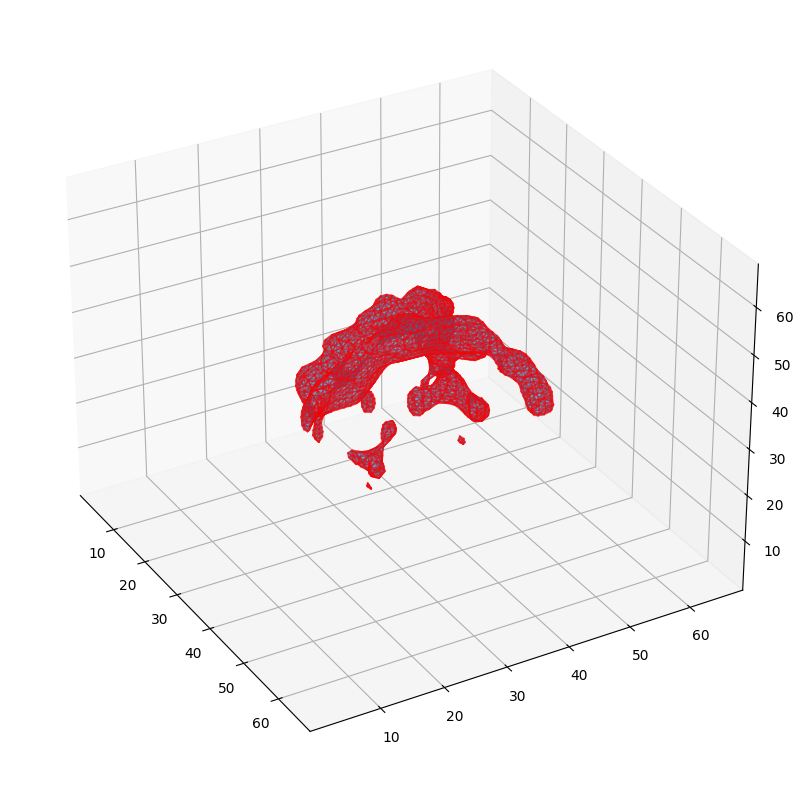

In [56]:
# Visualize a 3D mesh from the predicted volume mask
bool_pred_volume_mask = (pred_volume_mask > 0).astype(np.float32)

zoom_factor = (4, 1, 1)
resized_pred_volume_mask = zoom(bool_pred_volume_mask, zoom_factor)[30:-30, 30:-30, 30:-30]

rotated_pred_volume_mask = np.transpose(resized_pred_volume_mask, (2, 1, 0))

# Visualize the CSF Space Segmentation Mask in 3D dynamic viewer
def visualize_3d_mask(volume_mask):
    """Visualize a 3D mask using matplotlib's 3D capabilities."""
    # Apply a Gaussian filter to the volume mask to make the surface smoother
    smoothed_volume_mask = gaussian_filter(volume_mask, sigma=1)
    print(np.unique(smoothed_volume_mask))

    # Generate a 3D mesh from the smoothed volume mask
    verts, faces, _, _ = measure.marching_cubes(smoothed_volume_mask)

    # Create a new figure and add a 3D subplot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a 3D polygon collection
    mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='r')
    ax.add_collection3d(mesh)

    # Set the limits of the plot to the limits of the data
    max_range = np.array([volume_mask.shape[0]-1, volume_mask.shape[1]-1, volume_mask.shape[2]-1]).max() / 2.0

    mid_x = (volume_mask.shape[0]) / 2.0
    mid_y = (volume_mask.shape[1]) / 2.0
    mid_z = (volume_mask.shape[2]) / 2.0

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Rotate the view
    ax.view_init(azim=-30)

    # Show the plot
    plt.show()

# Assuming volume_mask is the mask calculated earlier
visualize_3d_mask(rotated_pred_volume_mask)

In [42]:
# Save model
#naming is model{num_images}e{num_epochs}.pth

PATH = "./Models/model100e300.pth"
torch.save(model.state_dict(), PATH)

In [13]:
# Load model
PATH = "./Models/model100e300.pth"

model = UNet3D(n_channels=1, n_classes=1).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>